<h1>Projeto de Identificação de Imagens</h1><br>

In [51]:
import os
import random
import tarfile
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from skimage import exposure
from skimage.util import montage
from scipy.ndimage import convolve

We start the project making sure that the database is usable by transforming every single image that we have in a smaller version.

In [5]:
# root directories
root_dir = 'images_png'
output_dir = 'image_database'
metadata_file = os.path.join(output_dir, 'metadata.txt')

with open(metadata_file, 'w') as meta:
    meta.write("")

# resize images
for subdir in os.listdir(root_dir):
    subdir_path = os.path.join(root_dir, subdir)
    if os.path.isdir(subdir_path):
        # create a new subdir for every subdir found in the root_dir
        output_subdir = os.path.join(output_dir, subdir)
        os.makedirs(output_subdir, exist_ok=True)

        # for every image, create a new line in class in metadata
        with open(metadata_file, 'a') as meta:
            meta.write(f"Class {subdir}:\n")

        for filename in os.listdir(subdir_path):
            if filename.lower().endswith('.png'):
                img = Image.open(os.path.join(subdir_path, filename))
                img_resized = img.resize((600, 600))
                output_path = os.path.join(output_subdir, filename)
                img_resized.save(output_path, 'PNG')
                print(f"Redimensionada: {filename} -> {output_path}")

                # write in the metadata file the last resized image
                with open(metadata_file, 'a') as meta:
                    meta.write(f"{filename}\n")

        with open(metadata_file, 'a') as meta:
            meta.write("\n")

print("Done!\nNew database created.")

Redimensionada: 0-01-V1-B.png -> image_database\0\0-01-V1-B.png
Redimensionada: 0-01-V1-W.png -> image_database\0\0-01-V1-W.png
Redimensionada: 0-01-V2-B.png -> image_database\0\0-01-V2-B.png
Redimensionada: 0-01-V2-W.png -> image_database\0\0-01-V2-W.png
Redimensionada: 0-02-V1-B.png -> image_database\0\0-02-V1-B.png
Redimensionada: 0-02-V1-W.png -> image_database\0\0-02-V1-W.png
Redimensionada: 0-02-V2-B.png -> image_database\0\0-02-V2-B.png
Redimensionada: 0-02-V2-W.png -> image_database\0\0-02-V2-W.png
Redimensionada: 0-03-V1-B.png -> image_database\0\0-03-V1-B.png
Redimensionada: 0-03-V1-W.png -> image_database\0\0-03-V1-W.png
Redimensionada: 0-03-V2-B.png -> image_database\0\0-03-V2-B.png
Redimensionada: 0-03-V2-W.png -> image_database\0\0-03-V2-W.png
Redimensionada: 0-04-V1-B.png -> image_database\0\0-04-V1-B.png
Redimensionada: 0-04-V1-W.png -> image_database\0\0-04-V1-W.png
Redimensionada: 0-04-V2-B.png -> image_database\0\0-04-V2-B.png
Redimensionada: 0-04-V2-W.png -> image_d

We choose randomly an image to show to the user to verify the resizing output.

Image '2\2-05-V2-B.png' size: (600, 600)


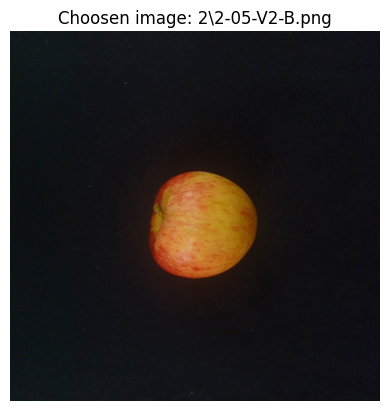

In [8]:
# list all possible image paths
all_images = []
for subdir in os.listdir(output_dir):
    subdir_path = os.path.join(output_dir, subdir)
    if os.path.isdir(subdir_path):
        for filename in os.listdir(subdir_path):
            all_images.append(os.path.join(subdir, filename))

if all_images:
    random_image_path = random.choice(all_images)
    img = Image.open(os.path.join(output_dir, random_image_path))
    
    # show image size
    print(f"Image '{random_image_path}' size: {img.size}")
    # show random image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Choosen image: {random_image_path}")
    plt.show()
else:
    print("No image found on the dataset!")

<h2>Dataset Augmentation</h2>
Every single augmentation function works randomly to have better results.

In [47]:
# From here on we are considering the "root dir" as the database
root_dir = 'image_database'
augmented_dir = 'augmented_dataset'
os.makedirs(augmented_dir, exist_ok=True)

def random_flip(img):
    if random.choice([True, False]):
        # Horizontal flip
        return ImageOps.mirror(img)
    else:
        # Vertical flip
        return ImageOps.flip(img)

def random_rotation(img):
    angle = random.randint(30, 60)
    rotated_img = img.rotate(angle, expand=True)
    
    # Apply a random flip to add rotation to the image
    # this ensures that flipped/mirror images and rotated images are never the same
    if random.choice([True, False]):
        rotated_img = ImageOps.mirror(rotated_img)
    if random.choice([True, False]):
        rotated_img = ImageOps.flip(rotated_img)
    
    return rotated_img

def random_noise(img):
    # Apply random noise to the image
    np_img = np.array(img)
    noise = np.random.normal(0, 25, np_img.shape).astype(np.int16)
    noisy_img = np.clip(np_img + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_img)

def random_crop(img):
    width, height = img.size
    # Defines that the zoom cant extend half the original size
    max_crop = min(width, height) // 2
    crop_size = width - random.randint(10, max_crop)
    
    left = (width - crop_size) // 2
    top = (height - crop_size) // 2
    right = left + crop_size
    bottom = top + crop_size

    cropped_img = img.crop((left, top, right, bottom))
    return cropped_img.resize((width, height), Image.Resampling.LANCZOS)

def random_log(image):
    image = np.array(image)
    image_normalized = image / 255.0
    # Apply log(1 + x)
    image_log = np.log(1 + image_normalized)
    # Return the image values between [0, 255]
    return Image.fromarray((image_log * 255).astype(np.uint8))

def random_exp(image):
    image = np.array(image)
    image_normalized = image / 255.0
    # exp(x) - 1
    image_exp = np.exp(image_normalized) - 1
    # Limits in [0, 1]
    image_exp = np.clip(image_exp, 0, 1)
    # Return the image values between [0, 255]
    return Image.fromarray((image_exp * 255).astype(np.uint8))

def random_avg_filter(image):
    image = np.array(image)
    # Defines a simple 3x3 mask
    kernel = np.ones((3, 3)) / 9
    # Apply convolve
    if len(image.shape) == 3:
        filtered_image = np.stack([convolve(image[..., i], kernel) for i in range(3)], axis=-1).astype(np.uint8)
    else:
        filtered_image  = convolve(image, kernel).astype(np.uint8)
    return Image.fromarray(filtered_image)

With the augmentation functions defined, we run for every single image in the dataset.

In [49]:
metadata_file = os.path.join(augmented_dir, 'metadata.txt')
is_a_test = True

for subdir in os.listdir(root_dir):
    subdir_path = os.path.join(root_dir, subdir)
    if os.path.isdir(subdir_path):
        output_subdir = os.path.join(augmented_dir, subdir)
        os.makedirs(output_subdir, exist_ok=True)

        with open(metadata_file, 'a') as meta:
            meta.write(f"Class {subdir}:\n")

        for filename in os.listdir(subdir_path):
            if filename.lower().endswith('.png'):
                img = Image.open(os.path.join(subdir_path, filename))

                # Save the original image
                img.save(os.path.join(output_subdir, f"{filename}_original.png"))
                with open(metadata_file, 'a') as meta:
                    meta.write(f"{filename}\n")

                if is_a_test:
                    # Call the augmentation functions and save the results
                    random_flip(img).save(os.path.join(output_subdir, f"{filename}_flip.png"))
                    random_rotation(img).save(os.path.join(output_subdir, f"{filename}_rot.png"))
                    random_noise(img).save(os.path.join(output_subdir, f"{filename}_noise.png"))
                    random_crop(img).save(os.path.join(output_subdir, f"{filename}_crop.png"))

                else:
                    # Call the specified augmentation functions
                    random_log(img).save(os.path.join(output_subdir, f"{filename}_log.png"))
                    random_exp(img).save(os.path.join(output_subdir, f"{filename}_exp.png"))
                    random_avg_filter(img).save(os.path.join(output_subdir, f"{filename}_avg.png"))

                print(f"Augmented: {filename} -> {output_subdir}")
                
        with open(metadata_file, 'a') as meta:
            meta.write("\n")

print("Done!\nData augmented!")

Augmented: 0-01-V1-B.png -> augmented_dataset\0
Augmented: 0-01-V1-W.png -> augmented_dataset\0
Augmented: 0-01-V2-B.png -> augmented_dataset\0
Augmented: 0-01-V2-W.png -> augmented_dataset\0
Augmented: 0-02-V1-B.png -> augmented_dataset\0
Augmented: 0-02-V1-W.png -> augmented_dataset\0
Augmented: 0-02-V2-B.png -> augmented_dataset\0
Augmented: 0-02-V2-W.png -> augmented_dataset\0
Augmented: 0-03-V1-B.png -> augmented_dataset\0
Augmented: 0-03-V1-W.png -> augmented_dataset\0
Augmented: 0-03-V2-B.png -> augmented_dataset\0
Augmented: 0-03-V2-W.png -> augmented_dataset\0
Augmented: 0-04-V1-B.png -> augmented_dataset\0
Augmented: 0-04-V1-W.png -> augmented_dataset\0
Augmented: 0-04-V2-B.png -> augmented_dataset\0
Augmented: 0-04-V2-W.png -> augmented_dataset\0
Augmented: 0-05-V1-B.png -> augmented_dataset\0
Augmented: 0-05-V1-W.png -> augmented_dataset\0
Augmented: 0-05-V2-B.png -> augmented_dataset\0
Augmented: 1-01-V1-B.png -> augmented_dataset\1
Augmented: 1-01-V1-W.png -> augmented_da

Now, as asked in the project instructions, we are going to compact all images to create the dataset.

In [30]:
tar_filename = 'augmented_dataset.tar.gz'

with tarfile.open(tar_filename, 'w:gz') as tar:
    tar.add(output_dir, arcname=os.path.basename(output_dir))

print(f"Done: {tar_filename}")

Done: augmented_dataset.tar.gz


Below we have a code to view the images by class.

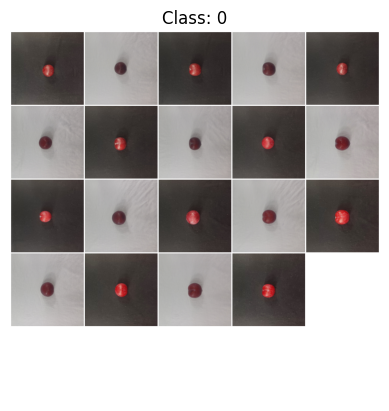

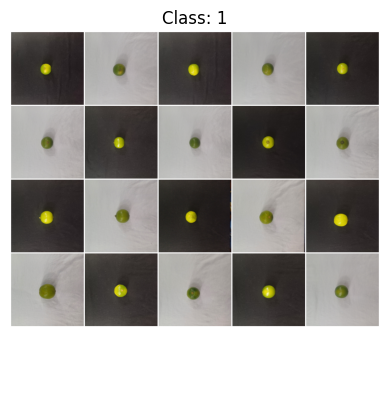

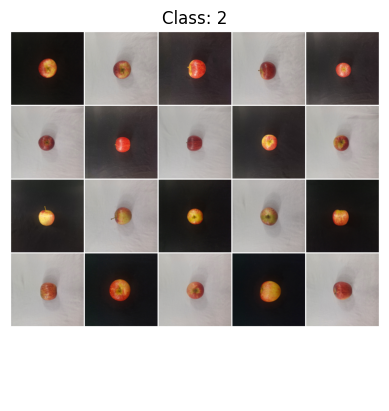

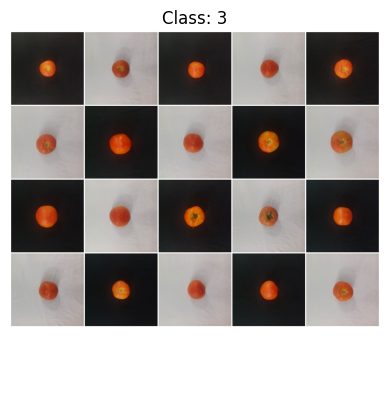

In [41]:
def load_images_for_class(class_dir, max_images=20):
    images = []
    for filename in os.listdir(class_dir):
        if filename.lower().endswith('original.png'):
            img = Image.open(os.path.join(class_dir, filename)).convert('RGB')
            img = img.resize((128, 128))
            images.append(np.array(img))
            if len(images) >= max_images:
                break
    return np.array(images)

def show_montage(images, title):
    """Exibe um conjunto de imagens em forma de montagem."""
    # We had problems using montage as it needs a 4D vector to work with colored images
    if images.ndim == 3:
        images = images[..., np.newaxis]
    if images.ndim == 4:
        # Using channel_axis=-1 we ensure that the dimensions are in the expected way for montage()
        m = montage(images, grid_shape=(5, 5), padding_width=2, fill=(255, 255, 255), channel_axis=-1)
        plt.imshow(m)
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print("Images are not in 4D.\nExiting")

# Show a montage for every single class using the original images
for class_name in os.listdir(augmented_dir):
    class_path = os.path.join(augmented_dir, class_name)
    if os.path.isdir(class_path):
        images = load_images_for_class(class_path)
        if len(images) > 0:
            show_montage(images, f"Class: {class_name}")

<h1>Dataset Normalization</h1>
Here we do some operations to create a normalized dataset.<br>
We start with basic functions for Class Prototype and Histograms.

In [70]:
def normalize_images(directory):
    images = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((600, 600))  # Redimensiona para o tamanho alvo
        img = np.array(img) / 255.0  # Normaliza a imagem para o intervalo [0, 1]
        images.append(img)
    return np.array(images)

def calculate_class_prototype(images):
    return np.mean(images, axis=0)

def calculate_histogram(image):
    return np.histogram(image.flatten(), bins=256, range=(0, 1))[0]

def calculate_average_histogram(images):
    histograms = np.array([calculate_histogram(img) for img in images])
    return np.mean(histograms, axis=0)

def calculate_histogram_variance(images):
    histograms = np.array([calculate_histogram(img) for img in images])
    return np.var(histograms, axis=0)

With the normalization functions made, we just call every single one for every class we have.


Class: 0


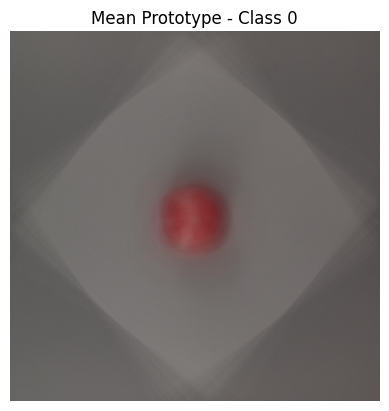

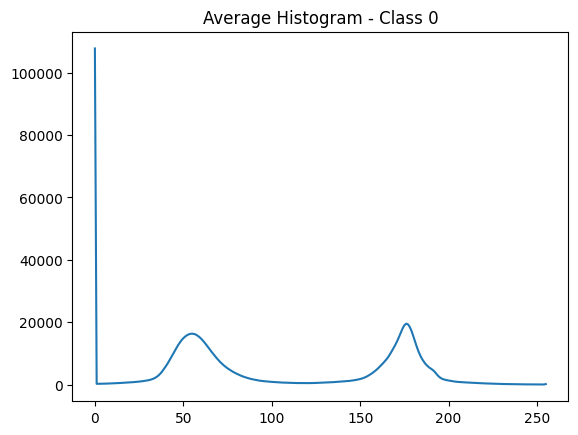

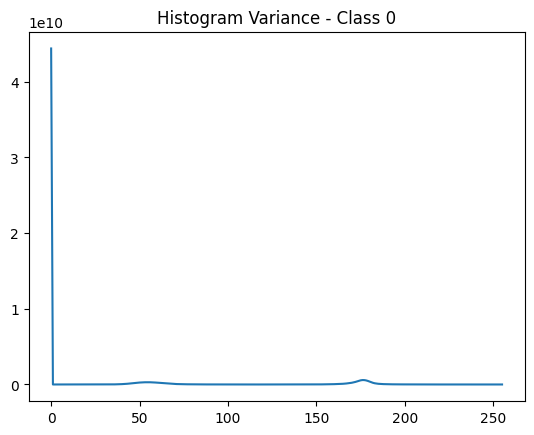


Class: 1


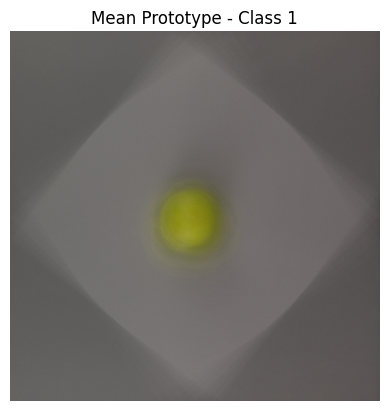

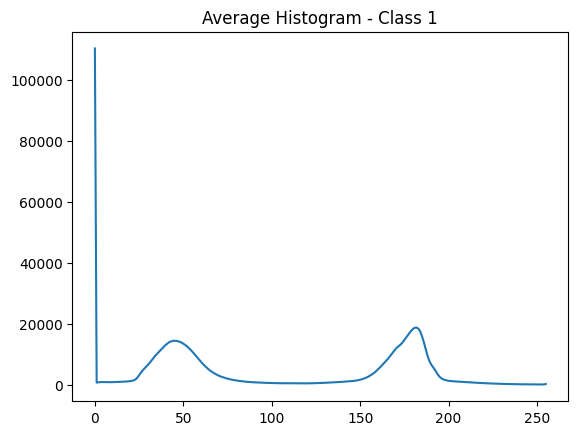

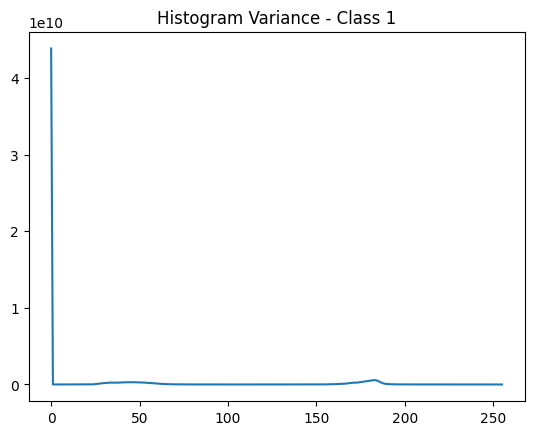


Class: 2


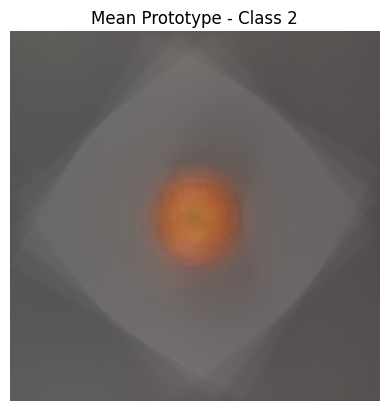

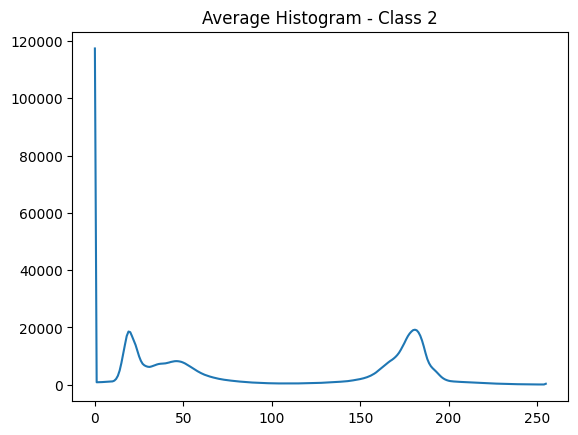

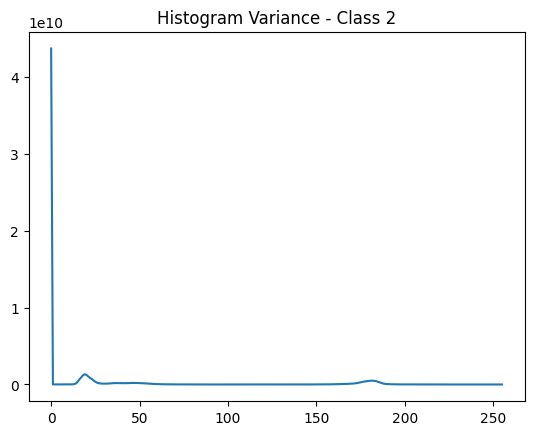


Class: 3


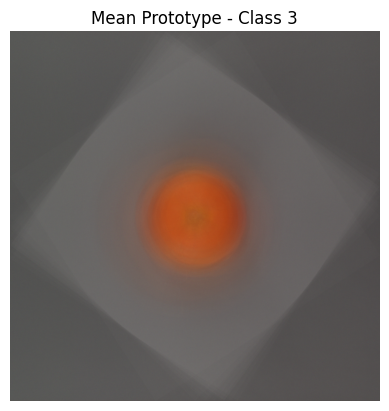

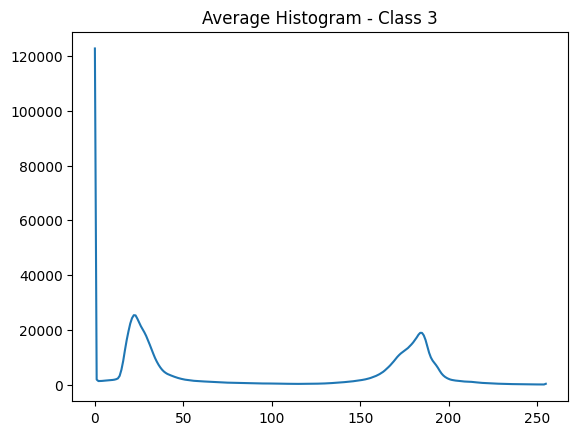

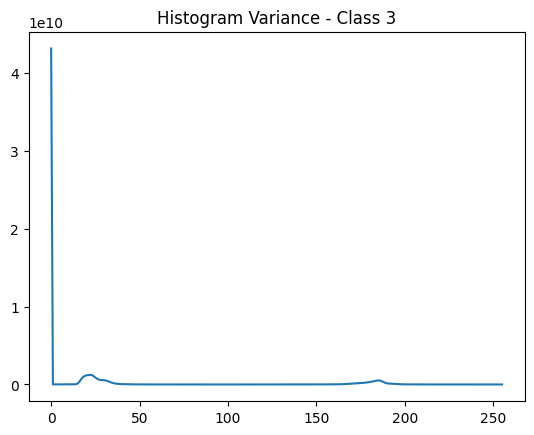

In [71]:
class_names = os.listdir(augmented_dir)
images = []
for class_name in class_names:
    class_path = os.path.join(augmented_dir, class_name)
    if os.path.isdir(class_path):
        print(f"\nClass: {class_name}")

        images = normalize_images(class_path)
        
        class_prototype = calculate_class_prototype(images)
        plt.imshow(class_prototype)
        plt.title(f"Mean Prototype - Class {class_name}")
        plt.axis('off')
        plt.show()
        
        avg_histogram = calculate_average_histogram(images)
        plt.plot(avg_histogram)
        plt.title(f"Average Histogram - Class {class_name}")
        plt.show()

        hist_variance = calculate_histogram_variance(images)
        plt.plot(hist_variance)
        plt.title(f"Histogram Variance - Class {class_name}")
        plt.show()